In [2]:
import os, shutil

# 清除 datasets script 缓存
shutil.rmtree(os.path.expanduser("~/.cache/huggingface/modules/datasets_modules/datasets/wikitext"), ignore_errors=True)
# 清除已下载数据缓存
shutil.rmtree(os.path.expanduser("~/.cache/huggingface/datasets/wikitext"), ignore_errors=True)


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, concatenate_datasets, DownloadConfig
import random

from peft import LoraConfig, get_peft_model

# ==========================================
# 0. 全局配置
# ==========================================
device = "cuda"
torch.backends.cuda.matmul.allow_tf32 = True

model_name = "NousResearch/Meta-Llama-3-8B"

HF_TOKEN = os.environ.get("HF_TOKEN", None)

# ✅ 关键：使用新缓存目录避免 wikitext 旧revision 404
os.environ["HF_HOME"] = "/tmp/hf_cache_clean"
os.environ["HF_DATASETS_CACHE"] = "/tmp/hf_cache_clean/datasets"
os.environ["HF_HUB_CACHE"] = "/tmp/hf_cache_clean/hub"

# ==========================================
# 1. 模型与 tokenizer
# ==========================================
tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"🚀 正在加载 {model_name}...")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=HF_TOKEN,
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    output_attentions=True,
).to(device)

# ✅ 只在指定层训练 LoRA
train_layers = [13, 15, 17]
target_layer = 13

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)

model = get_peft_model(model, lora_config)
model.train()
model.print_trainable_parameters()
print(f"🔒 LoRA 注入完成，仅训练 Layers {train_layers} 的 LoRA 参数 (Spectral target_layer={target_layer})。")

# ==========================================
# 2. WinoBias 数据
# ==========================================
print("📚 正在下载并处理大规模数据集...")

wino_configs = ['type1_pro', 'type1_anti', 'type2_pro', 'type2_anti']
wino_datasets = []

print(f"正在合并 WinoBias 的 {len(wino_configs)} 个子集...")
for config in wino_configs:
    ds = load_dataset("wino_bias", config, split="validation")
    wino_datasets.append(ds)

dataset_wino = concatenate_datasets(wino_datasets)

bias_pairs = []

def flip_gender(text):
    words = text.split()
    new_words = []
    changed = False
    for w in words:
        if w.lower() == "he": new_words.append("she"); changed=True
        elif w.lower() == "she": new_words.append("he"); changed=True
        elif w.lower() == "him": new_words.append("her"); changed=True
        elif w.lower() == "her": new_words.append("him"); changed=True
        elif w.lower() == "his": new_words.append("her"); changed=True
        else: new_words.append(w)
    return " ".join(new_words) if changed else None

for item in dataset_wino:
    text_orig = " ".join(item['tokens'])
    text_flip = flip_gender(text_orig)
    if text_flip:
        bias_pairs.append((text_orig, text_flip))

bias_pairs = bias_pairs[:1000]


# ==========================================
# 3. 本地 WinoBias 作为 normal_texts
# ==========================================
import glob

wino_local_dir = "/home/zikang.ding/dataset/WinoBias"   # 改成你实际路径

normal_texts = []
for path in glob.glob(os.path.join(wino_local_dir, "*.txt.test")):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            t = line.strip()
            if 20 < len(t) < 200:
                normal_texts.append(t)

# 如果你还想掺一点 jsonl 里的内容
jsonl_path = os.path.join(wino_local_dir, "winobias_type1_test.jsonl")
if os.path.exists(jsonl_path):
    import json
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            t = obj.get("sentence", "").strip()
            if 20 < len(t) < 200:
                normal_texts.append(t)

# 去重 + 截断长度，保证与 bias_pairs 同规模
normal_texts = list(dict.fromkeys(normal_texts))
if len(normal_texts) > len(bias_pairs):
    normal_texts = normal_texts[:len(bias_pairs)]

print(f"✅ 本地 normal_texts = {len(normal_texts)} 条")


print(f"✅ 数据准备完毕: {len(bias_pairs)} 对偏见样本 + {len(normal_texts)} 条复习样本")

# ==========================================
# 4. Loss 定义 (保持不变)
# ==========================================
class AdaptiveSpectralLoss(nn.Module):
    def __init__(self, target_layer):
        super().__init__()
        self.target_layer = target_layer

    def get_spectrum(self, layer_attn):
        B, H, S, _ = layer_attn.shape
        A_diag = torch.diagonal(layer_attn, dim1=-2, dim2=-1)
        col_sum = layer_attn.sum(dim=-2)
        indices = torch.arange(S).to(layer_attn.device)
        denominator = torch.clamp((S - indices).float().view(1, 1, -1), min=1.0)
        D_diag = col_sum / denominator
        return D_diag - A_diag

    def forward(self, attentions_he, attentions_she):
        attn_he = attentions_he[self.target_layer]
        attn_she = attentions_she[self.target_layer]

        spec_he = self.get_spectrum(attn_he)
        spec_she = self.get_spectrum(attn_she)

        diff_sq = (spec_he - spec_she) ** 2

        pronoun_attn_he = attn_he[:, :, -1, :]
        pronoun_attn_she = attn_she[:, :, -1, :]
        weight = (pronoun_attn_he + pronoun_attn_she) / 2
        weight = weight.detach()

        seq_len = diff_sq.shape[-1]
        sink_mask = torch.ones(seq_len).to(diff_sq.device)
        sink_mask[0] = 0.0

        weighted_loss = (diff_sq * weight * sink_mask).sum() / (sink_mask.sum() + 1e-6)
        return weighted_loss

# ==========================================
# 5. 训练循环
# ==========================================
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
spectral_criterion = AdaptiveSpectralLoss(target_layer=target_layer)

lambda_spec = 500.0
lambda_kl = 0.5
epochs = 3

print(f"\n🚀 开始大规模训练 (Epochs={epochs})...")

for epoch in range(epochs):
    total_loss = 0

    tasks = [0] * len(bias_pairs) + [1] * len(normal_texts)
    random.shuffle(tasks)

    for i, task_type in enumerate(tasks):
        optimizer.zero_grad(set_to_none=True)

        if task_type == 0:  # Bias
            text_he, text_she = bias_pairs[i % len(bias_pairs)]
            inputs = tokenizer(text_he, return_tensors="pt").to(device)
            if inputs['input_ids'].shape[1] > 128:
                continue

            out_student = model(**inputs, labels=inputs["input_ids"], output_attentions=True)

            with model.disable_adapter():
                with torch.no_grad():
                    out_ref = model(**inputs, output_attentions=False, output_hidden_states=False)

            prob_ref = F.softmax(out_ref.logits, dim=-1)
            log_prob_student = F.log_softmax(out_student.logits, dim=-1)
            kl_loss = F.kl_div(log_prob_student, prob_ref, reduction='batchmean')

            inputs_she = tokenizer(text_she, return_tensors="pt").to(device)
            if inputs_she['input_ids'].shape[1] != inputs['input_ids'].shape[1]:
                continue

            out_student_she = model(**inputs_she, output_attentions=True)
            spec_loss = spectral_criterion(out_student.attentions, out_student_she.attentions)

            loss = lambda_kl * kl_loss + lambda_spec * spec_loss

        else:  # Normal
            text = normal_texts[i % len(normal_texts)]
            inputs = tokenizer(text, return_tensors="pt").to(device)
            if inputs['input_ids'].shape[1] > 128:
                continue

            out_student = model(**inputs, labels=inputs["input_ids"])

            with model.disable_adapter():
                with torch.no_grad():
                    out_ref = model(**inputs, output_attentions=False, output_hidden_states=False)

            prob_ref = F.softmax(out_ref.logits, dim=-1)
            log_prob_student = F.log_softmax(out_student.logits, dim=-1)
            loss = F.kl_div(log_prob_student, prob_ref, reduction='batchmean')

        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())

        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch+1} | Step {i+1}/{len(tasks)} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} 完成 | Avg Loss: {total_loss/len(tasks):.4f}")

print("🎉 训练完成！")

# ==========================================
# 6. 最终评估
# ==========================================
model.eval()

inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt").to(device)
with torch.no_grad():
    loss = model(**inputs, labels=inputs["input_ids"]).loss
    ppl = torch.exp(loss.float()).item()

    with model.disable_adapter():
        loss_ref = model(**inputs, labels=inputs["input_ids"]).loss
    ppl_ref = torch.exp(loss_ref.float()).item()

print(f"\n🧠 原始 PPL: {ppl_ref:.2f}")
print(f"🧠 最终 PPL: {ppl:.2f}")

test_jobs = ["architect", "designer", "counselor"]
gaps = []

id_he = tokenizer.encode(" he", add_special_tokens=False)[-1]
id_she = tokenizer.encode(" she", add_special_tokens=False)[-1]

for job in test_jobs:
    text = f"The {job} said that"
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits[0, -1, :]
        probs = F.softmax(logits, dim=-1)
        p_he = probs[id_he].item()
        p_she = probs[id_she].item()
        gaps.append(abs(p_he - p_she))

print(f"⚖️ WinoBias 概率偏差 (Unseen Jobs): {np.mean(gaps):.4f}")


/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 正在加载 NousResearch/Meta-Llama-3-8B...


`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 19.64it/s]


trainable params: 13,631,488 || all params: 8,043,892,736 || trainable%: 0.1695
🔒 LoRA 注入完成，仅训练 Layers [13, 15, 17] 的 LoRA 参数 (Spectral target_layer=13)。
📚 正在下载并处理大规模数据集...
正在合并 WinoBias 的 4 个子集...


Using the latest cached version of the dataset since wino_bias couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'type1_pro' at /home/zikang.ding/.cache/huggingface/datasets/wino_bias/type1_pro/0.0.0/3f31267586e4408e3b3f77ec22198fd24ea8dc1d (last modified on Mon Jan 26 19:48:22 2026).
Using the latest cached version of the dataset since wino_bias couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'type1_anti' at /home/zikang.ding/.cache/huggingface/datasets/wino_bias/type1_anti/0.0.0/3f31267586e4408e3b3f77ec22198fd24ea8dc1d (last modified on Mon Jan 26 19:48:50 2026).
Using the latest cached version of the dataset since wino_bias couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'type2_pro' at /home/zikang.ding/.cache/huggingface/datasets/wino_bias/type2_pro/0.0.0/3f31267586e4408e3b3f77ec22198fd24ea8dc1d (last modified on Mon Jan 26 19:49:11 2026).
Using the latest cached ve

✅ 本地 normal_texts = 0 条
✅ 数据准备完毕: 1000 对偏见样本 + 0 条复习样本

🚀 开始大规模训练 (Epochs=3)...
Epoch 1 | Step 100/1000 | Loss: 0.0360
Epoch 1 | Step 200/1000 | Loss: 0.0630
Epoch 1 | Step 300/1000 | Loss: 0.0495
Epoch 1 | Step 400/1000 | Loss: 0.1729
Epoch 1 | Step 500/1000 | Loss: 0.1536
Epoch 1 | Step 600/1000 | Loss: 0.0385
Epoch 1 | Step 700/1000 | Loss: 0.0809
Epoch 1 | Step 800/1000 | Loss: 0.1414
Epoch 1 | Step 900/1000 | Loss: 0.0430
Epoch 1 | Step 1000/1000 | Loss: 0.0317
Epoch 1 完成 | Avg Loss: 0.1206
Epoch 2 | Step 100/1000 | Loss: 0.1859
Epoch 2 | Step 200/1000 | Loss: 0.1368
Epoch 2 | Step 300/1000 | Loss: 0.1217
Epoch 2 | Step 400/1000 | Loss: 0.4757
Epoch 2 | Step 500/1000 | Loss: 0.2225
Epoch 2 | Step 600/1000 | Loss: 0.0758
Epoch 2 | Step 700/1000 | Loss: 0.1212
Epoch 2 | Step 800/1000 | Loss: 0.0483
Epoch 2 | Step 900/1000 | Loss: 0.0945
Epoch 2 | Step 1000/1000 | Loss: 0.0480
Epoch 2 完成 | Avg Loss: 0.2045
Epoch 3 | Step 100/1000 | Loss: 0.1363
Epoch 3 | Step 200/1000 | Loss: 0.1374


In [3]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ Heatmap 已保存到: attn_L4_H6_denoised11.png
✅ Heatmap 已保存到: attn_L4_H6_denoised11.pdf


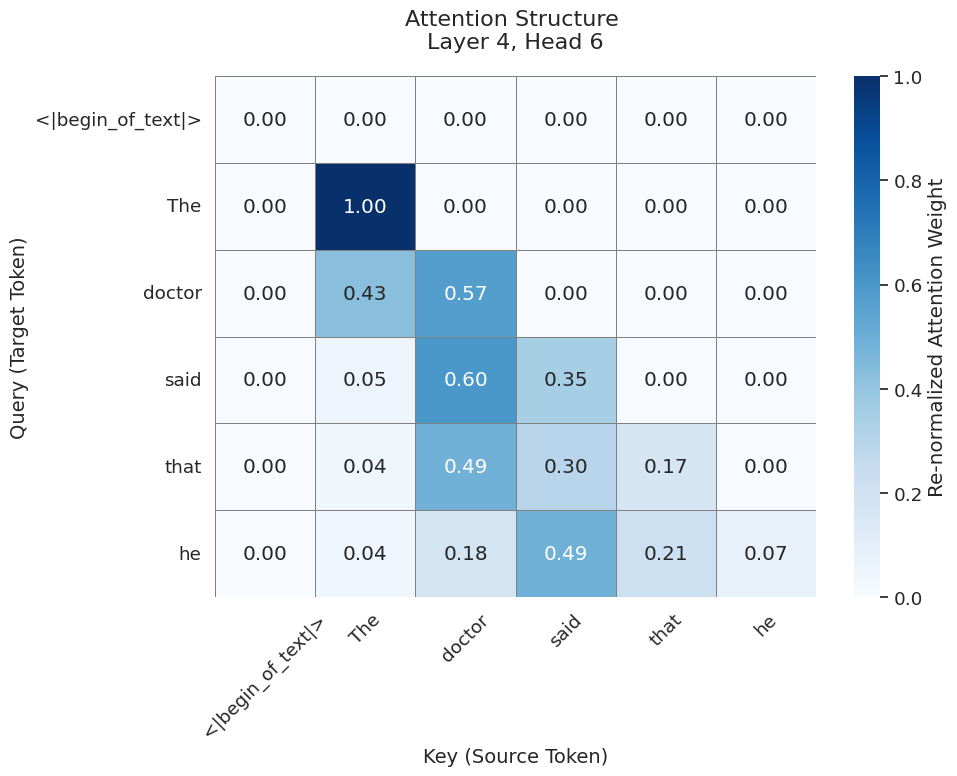

------------------------------
🧐 自动诊断报告 (Layer 4 Head 6):
代词 'he' 对职业词 'doctor' 的归一化关注度: 0.0393
------------------------------
✅ 结论: 无明显 Bias。
      注意力分布很均匀，没有过度集中在职业词上。


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# ==========================================
# 1. 准备数据
# ==========================================
model.eval()

text = "The doctor said that he"
inputs = tokenizer(text, return_tensors="pt").to(device)
tokens = [tokenizer.decode(t).strip() for t in inputs['input_ids'][0]]

# ==========================================
# 2. 提取 Attention 矩阵
# ==========================================
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    
    # 使用你之前发现的 Bias 最严重的层和头 (Layer 4, Head 6)
    target_layer = 4 
    target_head = 6
    
    # 提取原始矩阵 [Seq, Seq]
    # raw_matrix = outputs.attentions[target_layer][0, target_head, :, :].cpu().numpy()
    raw_matrix = outputs.attentions[target_layer][0, target_head].detach().to(torch.float32).cpu().numpy()

# ==========================================
# 3. 关键步骤：去除 Attention Sink (去噪)
# ==========================================
# 复制一份，以免修改原数据
attn_norm = raw_matrix.copy()

# A. 屏蔽第一列 (Index 0, 即 "The")
# 因为 GPT-2 默认把无法分配的注意力都扔给了第一个词，这会掩盖真正的 Bias
attn_norm[:, 0] = 0.0

# B. 重新归一化 (Re-normalization)
# 让每一行的和重新变成 1，这样我们能看到剩余词之间的相对权重
row_sums = attn_norm.sum(axis=1, keepdims=True)
# 防止除以 0 (虽然一般不会发生，但为了代码健壮性)
attn_norm = np.divide(attn_norm, row_sums, out=np.zeros_like(attn_norm), where=row_sums!=0)

# ==========================================
# 4. 绘制高清热力图 (Paper Ready)
# ==========================================
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) # 调整字体

# 绘制热力图
# 使用 "Blues" 色系，看起来更像“分析图表”
# vmin=0, vmax=1.0 确保颜色映射范围固定
heatmap = sns.heatmap(
    attn_norm, 
    xticklabels=tokens, 
    yticklabels=tokens, 
    cmap="Blues", 
    annot=True, 
    fmt=".2f", 
    cbar_kws={'label': 'Re-normalized Attention Weight'},
    linewidths=0.5, # 增加格子间距，更清晰
    linecolor='gray'
)

# 设置标题和坐标轴
plt.title(f"Attention Structure \nLayer {target_layer}, Head {target_head}", fontsize=16, pad=20)
plt.xlabel("Key (Source Token)", fontsize=14)
plt.ylabel("Query (Target Token)", fontsize=14)

# 调整刻度
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()

# 保存（推荐：高分辨率 + 紧边界）
save_path = f"attn_L{target_layer}_H{target_head}_denoised11.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")   # 或 dpi=600 更“paper ready”
print(f"✅ Heatmap 已保存到: {save_path}")

save_path = f"attn_L{target_layer}_H{target_head}_denoised11.pdf"
plt.savefig(f"attn_L{target_layer}_H{target_head}_denoised.pdf", bbox_inches="tight")
print(f"✅ Heatmap 已保存到: {save_path}")
plt.show()

# ==========================================
# 5. 自动解读结果
# ==========================================
# 获取 'he' (最后一行) 对 'doctor' (第二列) 的关注度
# tokens: ['The', 'doctor', 'said', 'that', 'he']
# indices:  0        1        2       3      4
bias_score = attn_norm[4, 1] 

print("-" * 30)
print(f"🧐 自动诊断报告 (Layer {target_layer} Head {target_head}):")
print(f"代词 'he' 对职业词 'doctor' 的归一化关注度: {bias_score:.4f}")
print("-" * 30)

if bias_score > 0.3:
    print("🚨 结论: 强 Bias！")
    print("      去除干扰后，'he' 极其强烈地指向了 'doctor'。")
    print("      这证明了两者之间存在刚性的结构连接。")
elif bias_score > 0.1:
    print("⚠️ 结论: 中度 Bias。")
    print("      'he' 对 'doctor' 有明显关注，但也被其他词分流了。")
else:
    print("✅ 结论: 无明显 Bias。")
    print("      注意力分布很均匀，没有过度集中在职业词上。")

正在计算全模型谱差异...
✅ 图已保存到: bias_map_comparison.png
✅ 图已保存到: bias_map_comparison.pdf


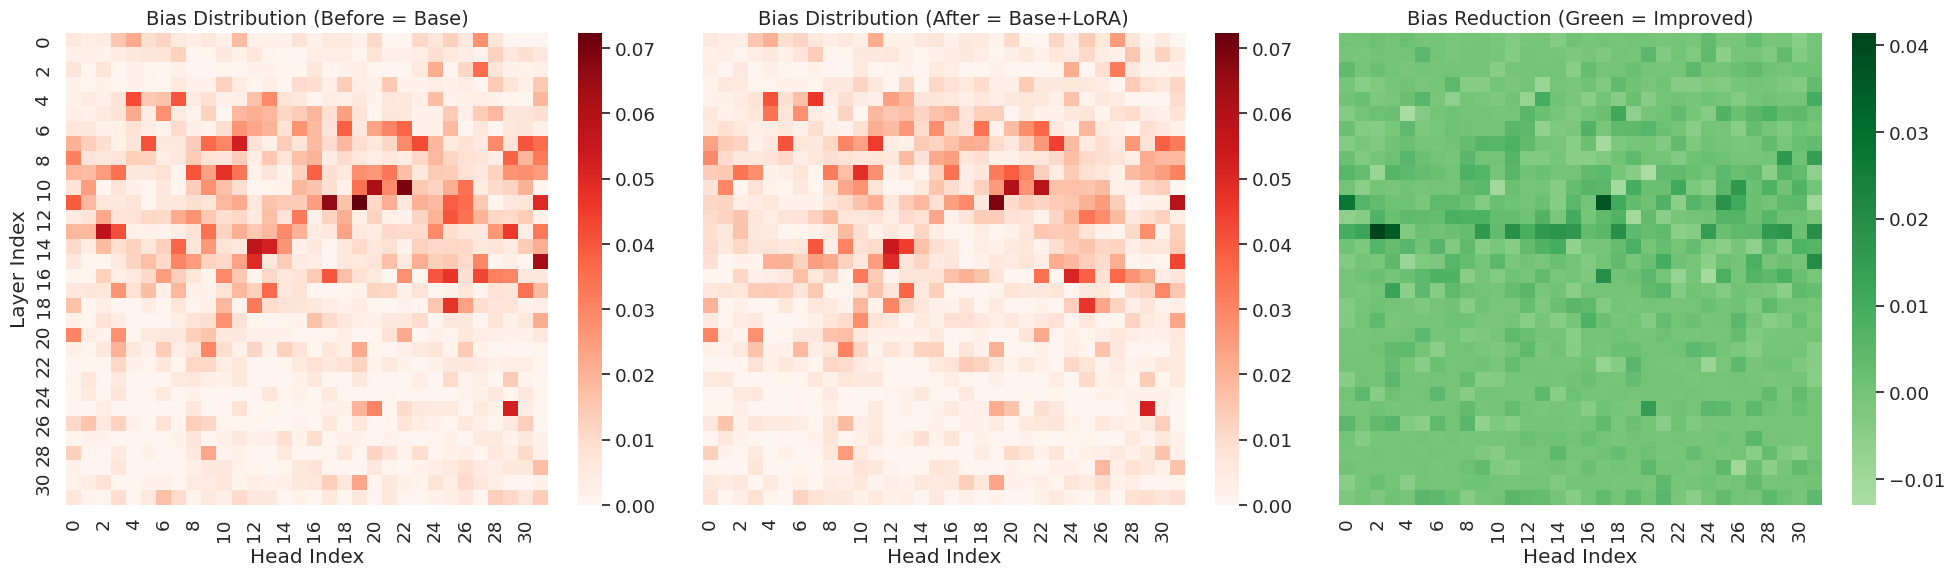

In [3]:
# 如果你没装 seaborn：先在 notebook 里跑 !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

# ==========================================
# 1. 准备数据
# ==========================================
text_he = "The doctor said that he"
text_she = "The doctor said that she"

# 假设你已经有：
# - tokenizer
# - model  (训练后的：Base + LoRA)
# - device = "cuda"
# 并且 model 在 GPU 上

def get_all_layer_spectrum(curr_model, text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        # ✅ 必须显式要 attentions（否则可能为 None）
        out = curr_model(**inputs, output_attentions=True, output_hidden_states=False)

    all_specs = []
    for layer_attn in out.attentions:
        # layer_attn: [1, Heads, Seq, Seq]
        layer_attn = layer_attn.squeeze(0)  # [Heads, Seq, Seq]

        # 计算谱
        A_diag = torch.diagonal(layer_attn, dim1=-2, dim2=-1)      # [Heads, Seq]
        col_sum = layer_attn.sum(dim=-2)                           # [Heads, Seq]
        indices = torch.arange(A_diag.shape[-1], device=layer_attn.device)
        denom = torch.clamp((A_diag.shape[-1] - indices).float(), min=1.0)  # [Seq]
        D_diag = col_sum / denom                                   # [Heads, Seq]
        spec = D_diag - A_diag                                     # [Heads, Seq]

        # ✅ BF16 -> FP32 再转 numpy（避免 bfloat16 numpy 报错）
        all_specs.append(spec.float().cpu().numpy())

    # [Layers, Heads, Seq]
    return np.array(all_specs)

# ==========================================
# 2. 计算 Bias Map
# ==========================================
print("正在计算全模型谱差异...")

# A. 原始模型的 Bias Map（✅ 用 base = disable_adapter）
with model.disable_adapter():
    specs_he_orig = get_all_layer_spectrum(model, text_he)
    specs_she_orig = get_all_layer_spectrum(model, text_she)

bias_map_orig = np.linalg.norm(specs_he_orig - specs_she_orig, axis=2)  # [Layers, Heads]

# B. 训练后模型的 Bias Map（带 LoRA）
specs_he_new = get_all_layer_spectrum(model, text_he)
specs_she_new = get_all_layer_spectrum(model, text_she)
bias_map_new = np.linalg.norm(specs_he_new - specs_she_new, axis=2)

# C. 变化量 (Delta)
delta_map = bias_map_orig - bias_map_new

# ==========================================
# 3. 画图 (Heatmap)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

vmin = 0
vmax = np.max(bias_map_orig)

sns.heatmap(bias_map_orig, ax=axes[0], cmap="Reds", vmin=vmin, vmax=vmax)
axes[0].set_title("Bias Distribution (Before = Base)", fontsize=14)
axes[0].set_xlabel("Head Index")
axes[0].set_ylabel("Layer Index")

sns.heatmap(bias_map_new, ax=axes[1], cmap="Reds", vmin=vmin, vmax=vmax)
axes[1].set_title("Bias Distribution (After = Base+LoRA)", fontsize=14)
axes[1].set_xlabel("Head Index")
axes[1].set_yticks([])

sns.heatmap(delta_map, ax=axes[2], cmap="Greens", center=0)
axes[2].set_title("Bias Reduction (Green = Improved)", fontsize=14)
axes[2].set_xlabel("Head Index")
axes[2].set_yticks([])

plt.tight_layout()

save_path_png = "bias_map_comparison.png"
plt.savefig(save_path_png, dpi=300, bbox_inches="tight")
print(f"✅ 图已保存到: {save_path_png}")

save_path_pdf = "bias_map_comparison.pdf"
plt.savefig(save_path_pdf, bbox_inches="tight")
print(f"✅ 图已保存到: {save_path_pdf}")

plt.show()

Computing spectral maps...


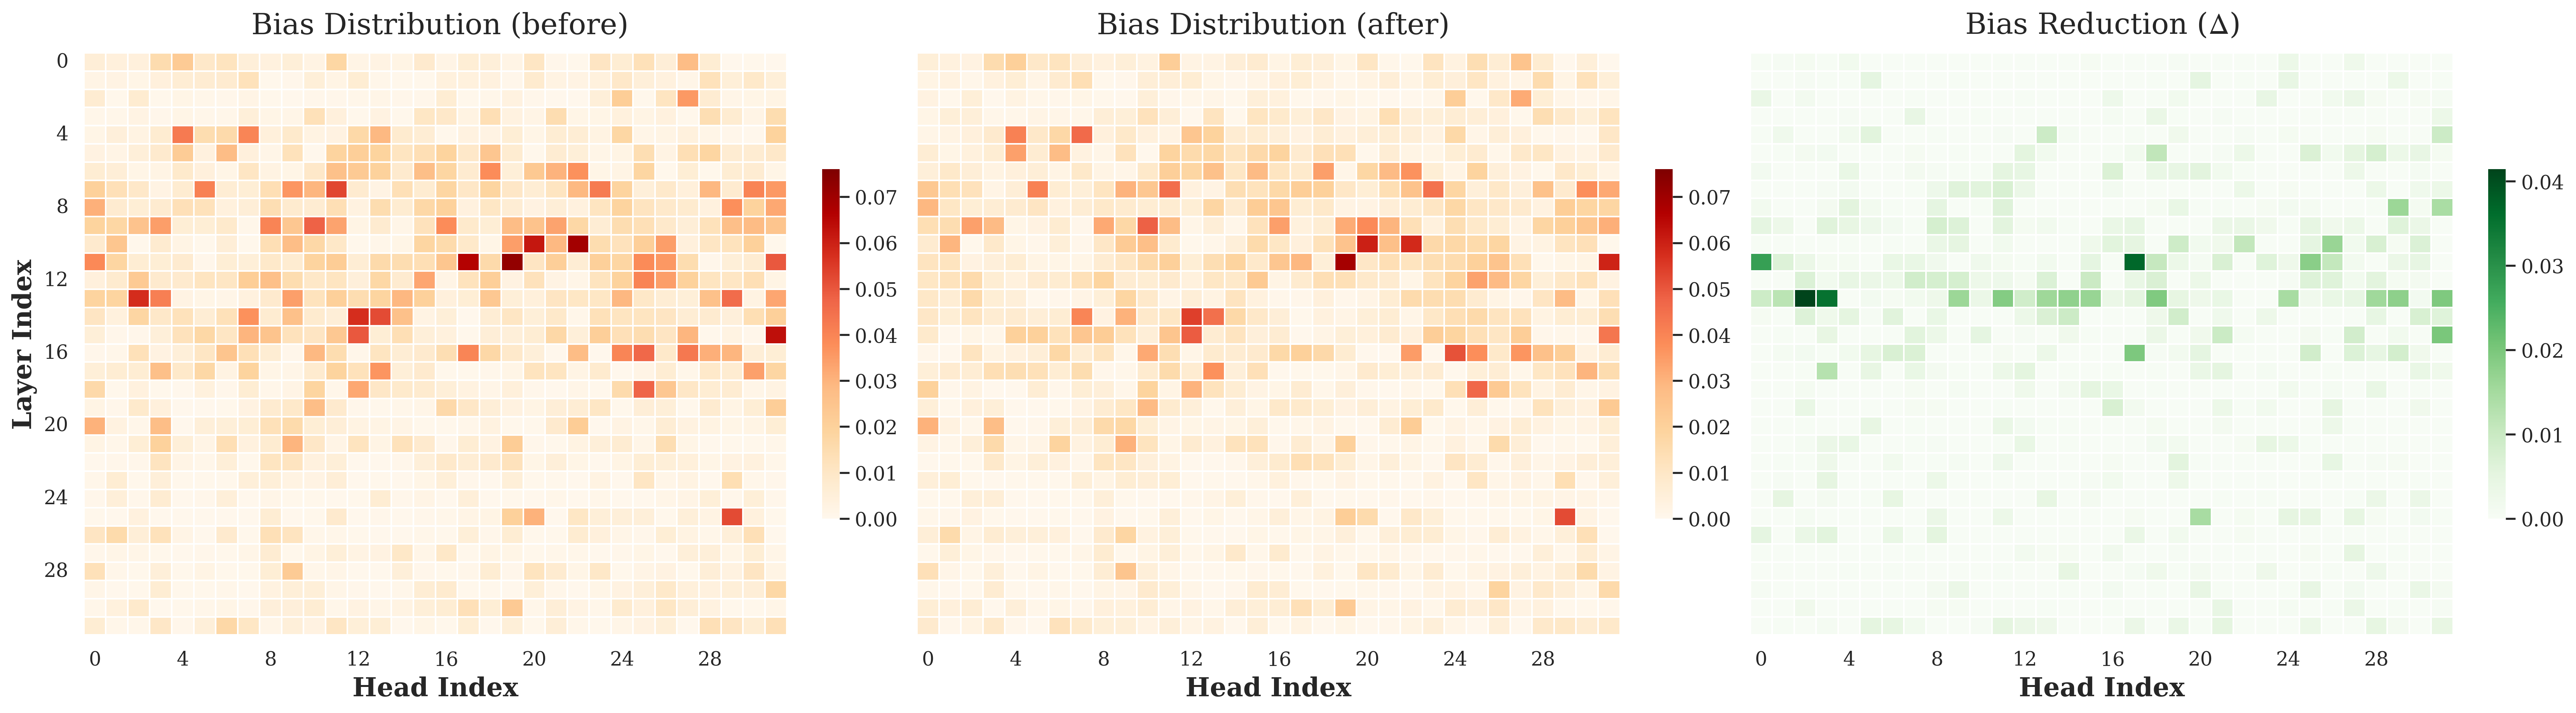

[Saved] A3_Bias_Spectrums_Comparison.pdf


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

# ==========================================
# 0. 全局样式配置 (ICML/NeurIPS Style)
# ==========================================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 14,
    "axes.titlesize": 18,        # 标题大一点
    "axes.labelsize": 16,        # 轴标签清晰
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
    "mathtext.fontset": "stix",  # 数学公式字体
})

# ==========================================
# 1. 准备数据 (保持您的逻辑不变)
# ==========================================
# 假设您已经在外部定义了 model, tokenizer, device
# text_he = "The doctor said that he"
# text_she = "The doctor said that she"

def get_all_layer_spectrum(curr_model, text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        # output_hidden_states=False, 只需要 attentions
        out = curr_model(**inputs, output_attentions=True)
    
    all_specs = []
    for layer_attn in out.attentions:
        # layer_attn: [1, Heads, Seq, Seq] -> Squeeze batch
        layer_attn = layer_attn.squeeze(0)  
        
        # 计算谱 (Spectral Logic)
        A_diag = torch.diagonal(layer_attn, dim1=-2, dim2=-1)
        col_sum = layer_attn.sum(dim=-2)
        indices = torch.arange(A_diag.shape[-1], device=layer_attn.device)
        # 防止除0
        denom = torch.clamp((A_diag.shape[-1] - indices).float(), min=1.0)
        D_diag = col_sum / denom
        spec = D_diag - A_diag
        
        all_specs.append(spec.float().cpu().numpy())

    # output shape: [Layers, Heads, Seq]
    return np.array(all_specs)

# ==========================================
# 2. 计算 Bias Map
# ==========================================
print("Computing spectral maps...")

# A. Base Model (Before)
with model.disable_adapter():
    specs_he_orig = get_all_layer_spectrum(model, text_he)
    specs_she_orig = get_all_layer_spectrum(model, text_she)

# Bias = L2 norm of difference across Sequence dim
# Shape: [Layers, Heads]
bias_map_orig = np.linalg.norm(specs_he_orig - specs_she_orig, axis=2)

# B. LoRA Model (After)
# 重新启用 adapter (如果是 PEFT model，默认是启用的，或者用 model.enable_adapter_layers())
# model.enable_adapter() # 视具体库版本而定，通常只要退出上面with即可
specs_he_new = get_all_layer_spectrum(model, text_he)
specs_she_new = get_all_layer_spectrum(model, text_she)
bias_map_new = np.linalg.norm(specs_he_new - specs_she_new, axis=2)

# C. Delta (Reduction)
# 正值 = Bias减少 (Good), 负值 = Bias增加 (Bad)
delta_map = bias_map_orig - bias_map_new

# ==========================================
# 3. [美化版] 绘图
# ==========================================
# 设置画布：宽长比适合平铺
fig, axes = plt.subplots(1, 3, figsize=(22, 6), constrained_layout=True)

# 统一量程，保证对比公平
vmin = 0
vmax = np.max(bias_map_orig) * 1.05 # 稍微留点余量

# --- 通用热力图参数 (关键：linewidths加白线) ---
heatmap_kws = {
    "linewidths": 0.5,      # 分割线宽度
    "linecolor": "white",   # 分割线颜色 (Tile效果)
    "square": False,        # 不需要强制正方形，因为Layer!=Head数
    "cbar_kws": {"shrink": 0.6} # Colorbar 缩短一点，不那么突兀
}

# 图1: Before (Base)
sns.heatmap(
    bias_map_orig, ax=axes[0], 
    cmap="OrRd", vmin=vmin, vmax=vmax, 
    **heatmap_kws
)
axes[0].set_title(r" Bias Distribution (before)", pad=12)
axes[0].set_ylabel("Layer Index", fontweight="bold")
axes[0].set_xlabel("Head Index", fontweight="bold")

# 图2: After (Ours/LoRA)
sns.heatmap(
    bias_map_new, ax=axes[1], 
    cmap="OrRd", vmin=vmin, vmax=vmax, 
    **heatmap_kws
)
axes[1].set_title(r" Bias Distribution (after)", pad=12)
axes[1].set_xlabel("Head Index", fontweight="bold")
axes[1].set_yticks([]) # 中间图不需要Y轴刻度

# 图3: Improvement (Delta)
# 使用 Greens：绿色越深 -> Bias消除得越多
delta_vmax = np.max(np.abs(delta_map))
sns.heatmap(
    delta_map, ax=axes[2], 
    cmap="Greens", vmin=0, vmax=delta_vmax, 
    **heatmap_kws
)
axes[2].set_title(r"Bias Reduction ($\Delta$)", pad=12)
axes[2].set_xlabel("Head Index", fontweight="bold")
axes[2].set_yticks([]) 

# 优化刻度显示：每隔5层/5头显示一个数字，避免拥挤
for ax in axes:
    # X轴刻度 (Heads)
    n_heads = bias_map_orig.shape[1]
    xticks = np.arange(0, n_heads, 4) # 每4个头标一个
    ax.set_xticks(xticks + 0.5)
    ax.set_xticklabels(xticks, rotation=0)
    
    # Y轴刻度 (Layers)
    if ax == axes[0]: # 只在第一个图显示Y轴
        n_layers = bias_map_orig.shape[0]
        yticks = np.arange(0, n_layers, 4) # 每4层标一个
        ax.set_yticks(yticks + 0.5)
        ax.set_yticklabels(yticks, rotation=0)

# 保存
save_path = "A3_Bias_Spectrums_Comparison.pdf"
plt.savefig(save_path.replace(".pdf", ".png"), dpi=300, bbox_inches="tight")
plt.savefig(save_path, format="pdf", bbox_inches="tight")

plt.show()
print(f"[Saved] {save_path}")

正在计算全模型谱差异...


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

✅ 图已保存到: bias_map_comparison_times_final.png


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

✅ 图已保存到: bias_map_comparison_times_final.pdf


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

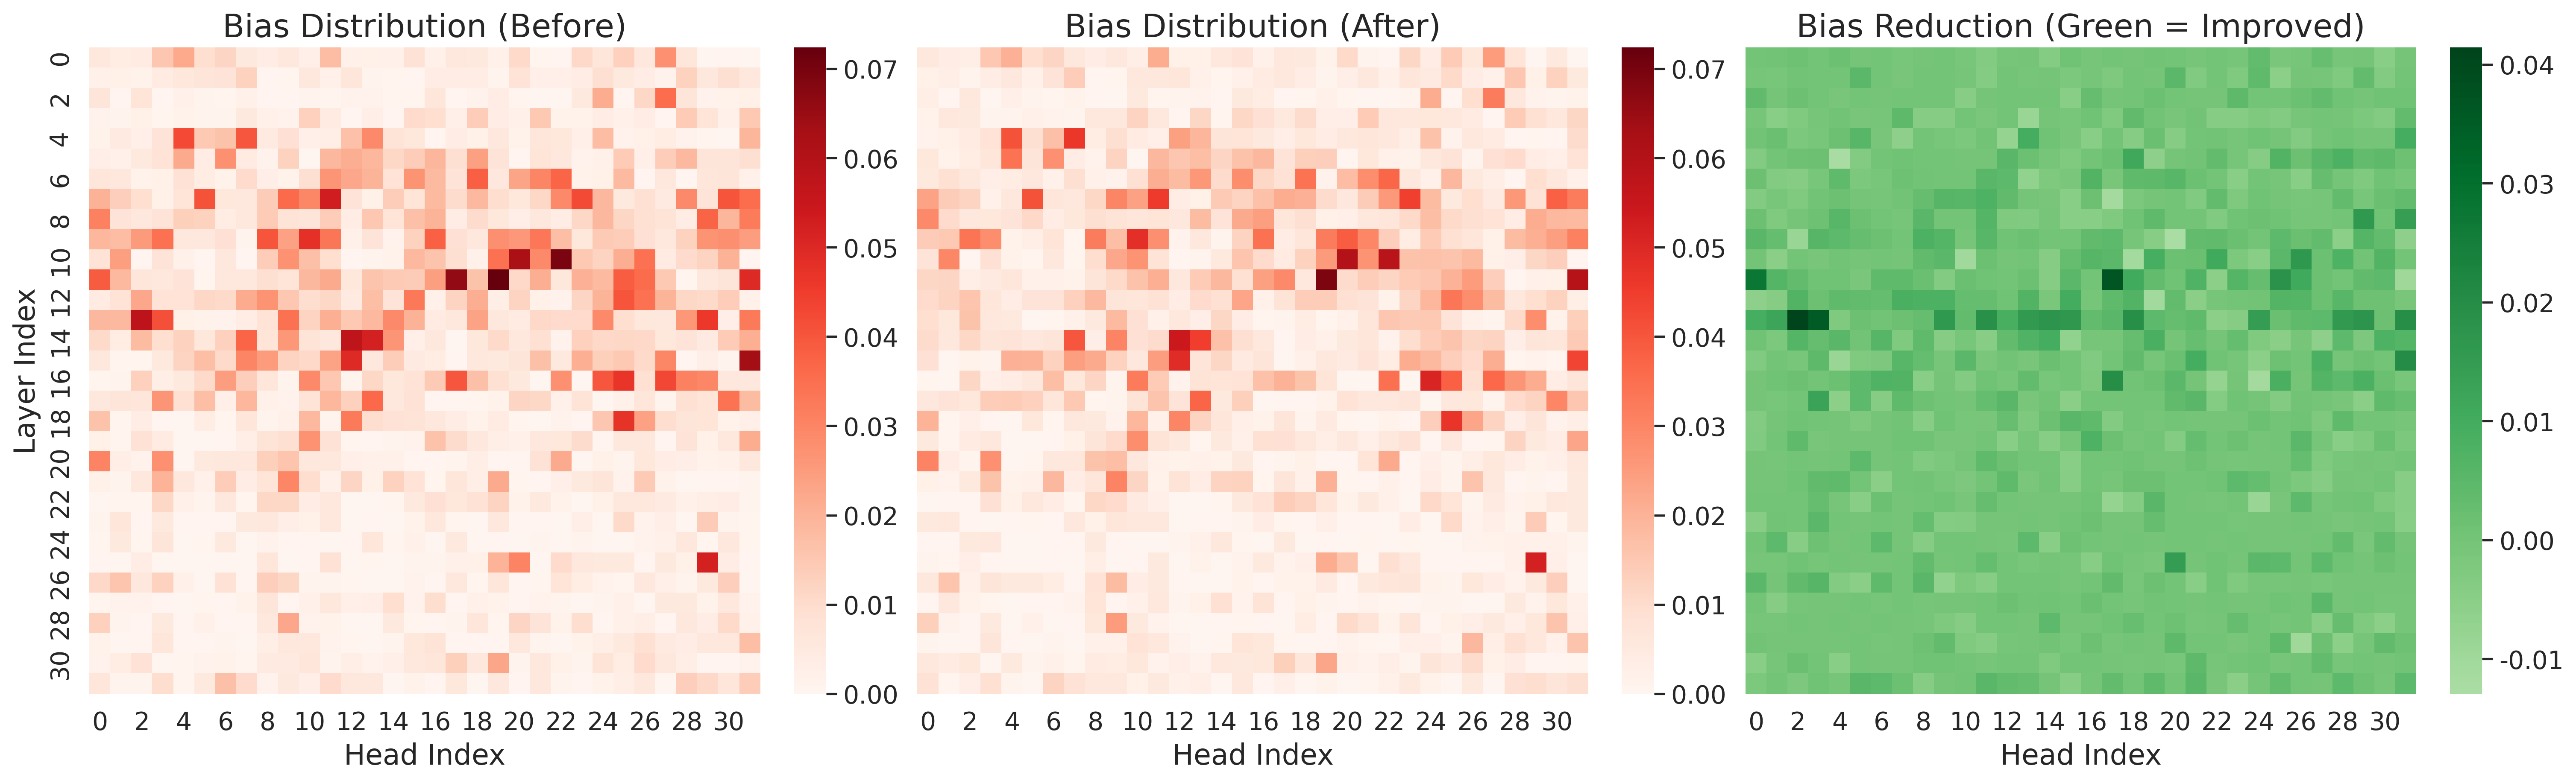

In [12]:
# 如果你没装 seaborn：先在 notebook 里跑 !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

# ==========================================
# 0. 全局绘图设置 (严格统一 Times New Roman)
# ==========================================
# 1. 基础重置
plt.rcParams.update(plt.rcParamsDefault)

# 2. 设置 Seaborn 风格 (White 风格最适合论文)
# 注意：必须在这里通过 rc 参数传入字体，否则 sns 会默认重置为 sans-serif
sns.set_theme(
    style="white",
    rc={
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
    }
)

# 3. 强制覆盖 Matplotlib 全局参数 (双重保险，确保无死角)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",  # 让数学公式 (如 Delta) 也匹配 Times 风格
    "axes.unicode_minus": False, # 解决负号显示
    "font.size": 14,             # 全局基础字号
    "axes.titlesize": 18,        # 子图标题字号
    "axes.labelsize": 16,        # 轴标签字号 (Layer Index 等)
    "xtick.labelsize": 14,       # 刻度字号
    "ytick.labelsize": 14,
    "figure.dpi": 300,           # 高清输出
    "pdf.fonttype": 42           # 确保导出 PDF 时字体是矢量 (Type 42)
})

# ==========================================
# 1. 准备数据
# ==========================================
text_he = "The doctor said that he"
text_she = "The doctor said that she"

# ⚠️ 注意：此处假设你已经在上下文中定义了 tokenizer, model, device
# 且 model 最好是 PeftModel 以支持 disable_adapter()

def get_all_layer_spectrum(curr_model, text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        # ✅ 必须显式要 attentions
        out = curr_model(**inputs, output_attentions=True, output_hidden_states=False)

    all_specs = []
    for layer_attn in out.attentions:
        # layer_attn: [1, Heads, Seq, Seq]
        layer_attn = layer_attn.squeeze(0)  # [Heads, Seq, Seq]

        # 计算谱
        A_diag = torch.diagonal(layer_attn, dim1=-2, dim2=-1)      # [Heads, Seq]
        col_sum = layer_attn.sum(dim=-2)                           # [Heads, Seq]
        indices = torch.arange(A_diag.shape[-1], device=layer_attn.device)
        denom = torch.clamp((A_diag.shape[-1] - indices).float(), min=1.0)  # [Seq]
        D_diag = col_sum / denom                                   # [Heads, Seq]
        spec = D_diag - A_diag                                     # [Heads, Seq]

        # ✅ BF16 -> FP32 再转 numpy
        all_specs.append(spec.float().cpu().numpy())

    # [Layers, Heads, Seq]
    return np.array(all_specs)

# ==========================================
# 2. 计算 Bias Map
# ==========================================
print("正在计算全模型谱差异...")

# A. 原始模型的 Bias Map
# ⚠️ 如果报错 'disable_adapter' 不存在，请确保你的 model 是通过 PeftModel.from_pretrained 加载的
with model.disable_adapter():
    specs_he_orig = get_all_layer_spectrum(model, text_he)
    specs_she_orig = get_all_layer_spectrum(model, text_she)

bias_map_orig = np.linalg.norm(specs_he_orig - specs_she_orig, axis=2)  # [Layers, Heads]

# B. 训练后模型的 Bias Map（带 LoRA）
specs_he_new = get_all_layer_spectrum(model, text_he)
specs_she_new = get_all_layer_spectrum(model, text_she)
bias_map_new = np.linalg.norm(specs_he_new - specs_she_new, axis=2)

# C. 变化量 (Delta)
delta_map = bias_map_orig - bias_map_new

# ==========================================
# 3. 画图 (Heatmap)
# ==========================================
# 使用 constrained_layout 自动调整间距，防止字体变大后重叠
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

vmin = 0
vmax = np.max(bias_map_orig)

# 图 1: Before
sns.heatmap(bias_map_orig, ax=axes[0], cmap="Reds", vmin=vmin, vmax=vmax)
axes[0].set_title("Bias Distribution (Before)") # 标题加粗更正式
axes[0].set_xlabel("Head Index")
axes[0].set_ylabel("Layer Index")

# 图 2: After
sns.heatmap(bias_map_new, ax=axes[1], cmap="Reds", vmin=vmin, vmax=vmax)
axes[1].set_title("Bias Distribution (After)")
axes[1].set_xlabel("Head Index")
axes[1].set_yticks([]) # 隐藏 Y 轴刻度

# 图 3: Reduction
sns.heatmap(delta_map, ax=axes[2], cmap="Greens", center=0)
axes[2].set_title("Bias Reduction (Green = Improved)")
axes[2].set_xlabel("Head Index")
axes[2].set_yticks([])

# 保存图片
save_path_png = "bias_map_comparison_times_final.png"
plt.savefig(save_path_png, dpi=300, bbox_inches="tight") # bbox_inches='tight' 防止标签被裁切
print(f"✅ 图已保存到: {save_path_png}")

save_path_pdf = "bias_map_comparison_times_final.pdf"
plt.savefig(save_path_pdf, bbox_inches="tight")
print(f"✅ 图已保存到: {save_path_pdf}")

plt.show()